# IBM Applied Data Science Capstone - Battle of the Neighborhoods

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Geographic Data: Vancouver and Toronto Postal Code and Coordinate Data

#### Vancouver

In [2]:
# load vancouver postal code and lat/long data
df_van_geo = pd.read_csv('C:/Users/David/Documents/AppliedDataScienceSpecialization/AppliedDataScienceCapstone/Week05/vancouver_geo_working.csv', index_col=0)

df_van_geo.head()

,CMA,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,Vancouver,V2S,Abbotsford,Abbotsford-Southeast,49.039718,-122.285384
1,Vancouver,V7X,Vancouver,Bentall Centre,49.286680,-123.120314
2,Vancouver,V5C,Burnaby,"Burnaby Heights, Willingdon Heights, West Cent...",49.276674,-123.007423
3,Vancouver,V5G,Burnaby,"Cascade-Schou, Douglas-Gilpin",49.249305,-122.993815
4,Vancouver,V6K,Vancouver,"Central Kitsilano, Greektown",49.265317,-123.165650


In [3]:
# count rows and columns
df_van_geo.shape

(82, 6)

In [4]:
# get Vancouver, Canada latitude and longitude
address = 'Vancouver, Canada'

geolocator = Nominatim(user_agent="van_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Vancouver are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Vancouver are 49.2608724, -123.1139529.


In [5]:
# create map of Vancouver using latitude and longitude values
map_vancouver = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_van_geo['Latitude'], df_van_geo['Longitude'], df_van_geo['Borough'], df_van_geo['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_vancouver)  
    
map_vancouver

#### Toronto

In [6]:
# load toronto postal code and lat/long data
df_tor_geo = pd.read_csv('C:/Users/David/Documents/AppliedDataScienceSpecialization/AppliedDataScienceCapstone/Week05/toronto_geo_working.csv', index_col=0)

df_tor_geo.head()

,CMA,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,Toronto,M1S,Scarborough,Agincourt,43.794200,-79.262029
1,Toronto,M8W,Etobicoke,"Alderwood, Long Branch",43.602414,-79.543484
2,Toronto,M3H,North York,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259
3,Toronto,M2K,North York,Bayview Village,43.786947,-79.385975
4,Toronto,M5M,North York,"Bedford Park, Lawrence Manor East",43.733283,-79.419750


In [7]:
df_tor_geo.shape

(99, 6)

In [8]:
# get Toronto, Canada latitude and longitude
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [9]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_tor_geo['Latitude'], df_tor_geo['Longitude'], df_tor_geo['Borough'], df_tor_geo['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## Foursquare Venue Information

In [10]:
CLIENT_ID = 'ZRW5HUMZ0ZQVUMFYTOI1QSGLLPHABHAHUMFQDXQZO5SQQBAE' # your Foursquare ID
CLIENT_SECRET = 'J1ZTK30RTR45YFAGFFCZTM3CEMCBCSL5LVKAPDWYS0SOVDXC' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
CATEGORY_ID = '4d4b7105d754a06374d81259'
radius = 500 # define radius

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZRW5HUMZ0ZQVUMFYTOI1QSGLLPHABHAHUMFQDXQZO5SQQBAE
CLIENT_SECRET:J1ZTK30RTR45YFAGFFCZTM3CEMCBCSL5LVKAPDWYS0SOVDXC


In [11]:
# function to get Foursquare venues informaiton for all neighborhoods
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CATEGORY_ID,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Vancouver

In [12]:
# get Vancouver neighborhoods venue data

van_neighborhood_venues = getNearbyVenues(names=df_van_geo['Neighborhood'],
                                   latitudes=df_van_geo['Latitude'],
                                   longitudes=df_van_geo['Longitude']
                                )

Abbotsford-Southeast
Bentall Centre
Burnaby Heights, Willingdon Heights, West Central Valley
Cascade-Schou, Douglas-Gilpin
Central Kitsilano, Greektown
Coquitlam - North
Coquitlam-North
Coquitlam-South
Delta-East
Delta-East Central
Delta-Northeast
Delta-Northwest
Delta-Southwest
East Big Bend, Stride Avenue, Edmonds, Cariboo-Armstrong
East Fairview, South Cambie
East Mount Pleasant
Government Road, Lake City, SFU, Burnaby Mountain
Killarney
Lakeview-Mayfield, Richmond Park, Kingsway-Beresford
Langley City
Langley Township-North
Langley Township-Northwest
Maple Ridge
Maple Ridge-East
Maple Ridge-West
Maywood, Marlborough, Okalla, Windsor
NE Downtown, Gastown, Harbour Centre, International Village, Vistory Square, Yaletown
New Westminster-Northeast
New Westminster-Southwest
North Grandview-Woodland
North Hastings-Sunrise
North Vancouver-East Central
North Vancouver-Inner East
North Vancouver-Northwest
North Vancouver-Outer East
North Vancouver-South Central
North Vancouver-Southwest
Nort

In [13]:
van_neighborhood_venues.shape

(816, 7)

#### Toronto

In [14]:
# get Toronto neighborhoods venue data

tor_neighborhood_venues = getNearbyVenues(names=df_tor_geo['Neighborhood'],
                                   latitudes=df_tor_geo['Latitude'],
                                   longitudes=df_tor_geo['Longitude']
                                )

Agincourt
Alderwood, Long Branch
Bathurst Manor, Wilson Heights, Downsview North
Bayview Village
Bedford Park, Lawrence Manor East
Berczy Park
Birch Cliff, Cliffside West
Brockton, Parkdale Village, Exhibition Place
Business reply mail Processing Centre, South Central Letter Processing Plant Toronto
Caledonia-Fairbanks
Canada Post Gateway Processing Centre
Cedarbrae
Central Bay Street
Christie
Church and Wellesley
Clarks Corners, Tam O'Shanter, Sullivan
Cliffside, Cliffcrest, Scarborough Village West
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Commerce Court, Victoria Hotel
Davisville
Davisville North
Del Ray, Mount Dennis, Keelsdale and Silverthorn
Don Mills-M3B
Don Mills-M3C
Dorset Park, Wexford Heights, Scarborough Town Centre
Downsview-M3K
Downsview-M3L
Downsview-M3M
Downsview-M3N
Dufferin, Dovercourt Village
East Toronto, Broadview North (Old East York)
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Fair

In [15]:
tor_neighborhood_venues.shape

(1659, 7)

### Explore Foursquare Venue Information

#### Vancouver

In [16]:
# count Vancouver venues by neighborhood
van_neighborhood_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Abbotsford-Southeast,3,3,3,3,3,3
Bentall Centre,57,57,57,57,57,57
"Burnaby Heights, Willingdon Heights, West Central Valley",4,4,4,4,4,4
"Central Kitsilano, Greektown",29,29,29,29,29,29
Coquitlam-South,20,20,20,20,20,20
Delta-Northeast,5,5,5,5,5,5
Delta-Southwest,2,2,2,2,2,2
"East Big Bend, Stride Avenue, Edmonds, Cariboo-Armstrong",5,5,5,5,5,5
"East Fairview, South Cambie",8,8,8,8,8,8


In [17]:
# determine number of unique venue categories for Vancouver
print('There are {} uniques categories.'.format(len(van_neighborhood_venues['Venue Category'].unique())))

There are 72 uniques categories.


#### Toronto

In [18]:
# count Toronto venues by neighborhood
tor_neighborhood_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,3,3,3,3,3,3
"Alderwood, Long Branch",4,4,4,4,4,4
"Bathurst Manor, Wilson Heights, Downsview North",9,9,9,9,9,9
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",21,21,21,21,21,21
Berczy Park,52,52,52,52,52,52
"Birch Cliff, Cliffside West",4,4,4,4,4,4
"Brockton, Parkdale Village, Exhibition Place",17,17,17,17,17,17
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",5,5,5,5,5,5


In [19]:
# determine number of unique venue categories for Toronto
print('There are {} uniques venue categories for Toronto.'.format(len(tor_neighborhood_venues['Venue Category'].unique())))

There are 91 uniques venue categories for Toronto.


## Analyze Neighborhood Venues

#### Vancouver

In [20]:
# one hot encoding
vancouver_onehot = pd.get_dummies(van_neighborhood_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
vancouver_onehot['Neighborhood'] = van_neighborhood_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [vancouver_onehot.columns[-1]] + list(vancouver_onehot.columns[:-1])
vancouver_onehot = vancouver_onehot[fixed_columns]

vancouver_onehot.head()

,Neighborhood,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Breakfast Spot,Burger Joint,Burrito Place,Cafeteria,Café,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,Greek Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hot Dog Joint,Hotpot Restaurant,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Korean Restaurant,Kosher Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Noodle House,Pizza Place,Poke Place,Portuguese Restaurant,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,Soup Place,South Indian Restaurant,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Abbotsford-Southeast,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,Abbotsford-Southeast,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Abbotsford-Southeast,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Bentall Centre,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Bentall Centre,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [21]:
vancouver_onehot.shape

(816, 73)

In [22]:
#group by neighborhood and sum count of venue categories
vancouver_sum_grouped = vancouver_onehot.groupby('Neighborhood').sum().reset_index()
vancouver_sum_grouped['Total'] = vancouver_sum_grouped.sum(axis=1)
vancouver_sum_grouped

,Neighborhood,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Breakfast Spot,Burger Joint,Burrito Place,Cafeteria,Café,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,Greek Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hot Dog Joint,Hotpot Restaurant,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Korean Restaurant,Kosher Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Noodle House,Pizza Place,Poke Place,Portuguese Restaurant,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,Soup Place,South Indian Restaurant,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Total
0,Abbotsford-Southeast,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3
1,Bentall Centre,0,5,0,1,0,0,0,0,0,1,1,0,1,7,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,7,0,0,1,1,0,0,0,0,0,0,4,0,3,0,0,0,1,1,0,0,0,1,0,0,0,0,0,8,0,1,4,0,0,0,0,2,0,1,1,0,1,57
2,"Burnaby Heights, Willingdon Heights, West Cent...",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,4
3,"Central Kitsilano, Greektown",0,0,0,0,1,1,0,0,0,1,1,0,0,2,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,2,0,1,0,0,0,1,0,1,0,0,0,1,3,0,0,0,1,0,0,0,0,0,0,1,0,2,0,0,2,2,29
4,Coquitlam-South,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,2,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,2,0,2,0,0,0,0,0,0,2,1,0,0,2,20
5,Delta-Northeast,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,5
6,Delta-Southwest,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2
7,"East Big Bend, Stride Avenue, Edmonds, Cariboo...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,5
8,"East Fairview, South Cambie",0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,8
9,East Mount Pleasant,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,2,11


In [23]:
vancouver_sum_grouped.shape

(55, 74)

In [24]:
# examine top 5 venues in each neighborhood
van_num_top_venues = 6

for hood in vancouver_sum_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = vancouver_sum_grouped[vancouver_sum_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','sum']
    temp = temp.iloc[2:]
    temp['sum'] = temp['sum'].astype(int)
    #temp = temp.round({'freq': 2})
    print(temp.sort_values('sum', ascending=False).reset_index(drop=True).head(van_num_top_venues))
    print('\n')

----Abbotsford-Southeast----
                       venue  sum
0                      Total    3
1           Sushi Restaurant    1
2         Chinese Restaurant    1
3                Pizza Place    1
4  Japanese Curry Restaurant    0
5        Japanese Restaurant    0


----Bentall Centre----
                 venue  sum
0                Total   57
1           Restaurant    8
2                 Café    7
3           Food Truck    7
4  American Restaurant    5
5   Italian Restaurant    4


----Burnaby Heights, Willingdon Heights, West Central Valley----
                      venue  sum
0                     Total    4
1       Japanese Restaurant    1
2          Sushi Restaurant    1
3        Mexican Restaurant    1
4                      Café    1
5  Mediterranean Restaurant    0


----Central Kitsilano, Greektown----
                           venue  sum
0                          Total   29
1                    Pizza Place    3
2          Vietnamese Restaurant    2
3  Vegetarian / Vegan R

                   venue  sum
0                  Total   40
1     Chinese Restaurant    5
2         Sandwich Place    4
3  Vietnamese Restaurant    3
4            Pizza Place    3
5   Fast Food Restaurant    3


----Surrey-Upper East----
               venue  sum
0              Total    3
1              Diner    1
2        Pizza Place    1
3  Indian Restaurant    1
4    Thai Restaurant    0
5         Taco Place    0


----Surrey-Upper West----
                             venue  sum
0                            Total    3
1                Indian Restaurant    2
2                      Snack Place    1
3                 Malay Restaurant    0
4          New American Restaurant    0
5  Molecular Gastronomy Restaurant    0


----UBC----
                 venue  sum
0                Total   11
1  Japanese Restaurant    3
2     Asian Restaurant    1
3   Falafel Restaurant    1
4     Sushi Restaurant    1
5       Sandwich Place    1


----Waterfron, Coal Harbour, Canada Place----
              

In [25]:
vancouver_mean_grouped = vancouver_onehot.groupby('Neighborhood').mean().reset_index()
vancouver_mean_grouped

,Neighborhood,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Breakfast Spot,Burger Joint,Burrito Place,Cafeteria,Café,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,Greek Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hot Dog Joint,Hotpot Restaurant,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Korean Restaurant,Kosher Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Noodle House,Pizza Place,Poke Place,Portuguese Restaurant,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,Soup Place,South Indian Restaurant,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Abbotsford-Southeast,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.00,0.333333,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000
1,Bentall Centre,0.0,0.087719,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000,0.000,0.017544,0.017544,0.000,0.017544,0.122807,0.000000,0.00,0.017544,0.00,0.017544,0.000000,0.000000,0.017544,0.0,0.0,0.000000,0.000000,0.017544,0.000000,0.000000,0.000000,0.122807,0.000000,0.000000,0.017544,0.017544,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.070175,0.000000,0.052632,0.000000,0.000000,0.000000,0.017544,0.017544,0.000000,0.000000,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000,0.000000,0.140351,0.000000,0.017544,0.070175,0.000000,0.0,0.00,0.000000,0.035088,0.000000,0.017544,0.017544,0.000000,0.017544
2,"Burnaby Heights, Willingdon Heights, West Cent...",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.250000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000
3,"Central Kitsilano, Greektown",0.0,0.000000,0.000000,0.000000,0.034483,0.034483,0.000000,0.000000,0.000,0.034483,0.034483,0.000,0.000000,0.068966,0.000000,0.00,0.034483,0.00,0.034483,0.000000,0.034483,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034483,0.034483,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.034483,0.000000,0.068966,0.000000,0.034483,0.000000,0.000000,0.000000,0.034483,0.000000,0.034483,0.000000,0.000000,0.000000,0.034483,0.103448,0.000000,0.000000,0.000000,0.034483,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.034483,0.000000,0.068966,0.000000,0.000000,0.068966,0.068966
4,Coquitlam-South,0.0,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.050000,0.000000,0.00,0.000000,0.05,0.050000,0.050000,0.000000,0.000000,0.0,0.0,0.000

In [26]:
vancouver_mean_grouped.shape

(55, 73)

In [27]:
# examine frequency of top 5 venues in each neighborhood
van_num_top_venues = 5

for hood in vancouver_mean_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = vancouver_mean_grouped[vancouver_mean_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(van_num_top_venues))
    print('\n')

----Abbotsford-Southeast----
                venue  freq
0  Chinese Restaurant  0.33
1    Sushi Restaurant  0.33
2         Pizza Place  0.33
3  African Restaurant  0.00
4    Malay Restaurant  0.00


----Bentall Centre----
                 venue  freq
0           Restaurant  0.14
1                 Café  0.12
2           Food Truck  0.12
3  American Restaurant  0.09
4   Italian Restaurant  0.07


----Burnaby Heights, Willingdon Heights, West Central Valley----
                 venue  freq
0     Sushi Restaurant  0.25
1   Mexican Restaurant  0.25
2  Japanese Restaurant  0.25
3                 Café  0.25
4   African Restaurant  0.00


----Central Kitsilano, Greektown----
                   venue  freq
0            Pizza Place  0.10
1  Vietnamese Restaurant  0.07
2       Sushi Restaurant  0.07
3                   Café  0.07
4     Italian Restaurant  0.07


----Coquitlam-South----
                   venue  freq
0  Vietnamese Restaurant   0.1
1       Sushi Restaurant   0.1
2             Resta

                 venue  freq
0  Japanese Restaurant  0.27
1           Food Court  0.09
2                 Café  0.09
3   Falafel Restaurant  0.09
4       Sandwich Place  0.09


----Waterfron, Coal Harbour, Canada Place----
                 venue  freq
0                 Café  0.18
1  Japanese Restaurant  0.12
2  American Restaurant  0.12
3   Italian Restaurant  0.06
4            Gastropub  0.06


----West Fairview, Granville Island, NE Shaughnessy----
                   venue  freq
0         Breakfast Spot  0.33
1                 Bakery  0.17
2            Pizza Place  0.17
3    Japanese Restaurant  0.17
4  Vietnamese Restaurant  0.17


----West Kensington-Cedar Cottage, NE Riley Park-Little Mountain----
                   venue  freq
0     Chinese Restaurant  0.17
1  Vietnamese Restaurant  0.11
2                 Bakery  0.11
3    Filipino Restaurant  0.11
4                   Café  0.06


----West Kerrisdale, South Dunbar-Southlands, Musqueam----
                             venue  freq
0

In [28]:
# put venue information in dataframe
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [29]:
# create new dataframe with neighborhood and venue information and display top 10 venues by neighborhood
van_num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(van_num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
van_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
van_neighborhoods_venues_sorted['Neighborhood'] = vancouver_mean_grouped['Neighborhood']

for ind in np.arange(vancouver_mean_grouped.shape[0]):
    van_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(vancouver_mean_grouped.iloc[ind, :], van_num_top_venues)

van_neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbotsford-Southeast,Chinese Restaurant,Pizza Place,Sushi Restaurant,Ethiopian Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
1,Bentall Centre,Restaurant,Café,Food Truck,American Restaurant,Seafood Restaurant,Italian Restaurant,Japanese Restaurant,Steakhouse,Gastropub,Greek Restaurant
2,"Burnaby Heights, Willingdon Heights, West Cent...",Japanese Restaurant,Mexican Restaurant,Sushi Restaurant,Café,Vietnamese Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant
3,"Central Kitsilano, Greektown",Pizza Place,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Italian Restaurant,Café,French Restaurant,Indian Restaurant,Diner,Japanese Restaurant
4,Coquitlam-South,Vietnamese Restaurant,Sandwich Place,Fast Food Restaurant,Sushi Restaurant,Restaurant,Greek Restaurant,Dim Sum Restaurant,Deli / Bodega,Comfort Food Restaurant,Pizza Place
5,Delta-Northeast,Pizza Place,Vietnamese Restaurant,Sandwich Place,Sushi Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
6,Delta-Southwest,Pizza Place,Restaurant,Vietnamese Restaurant,Ethiopian Restaurant,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant
7,"East Big Bend, Stride Avenue, Edmonds, Cariboo...",Indian Restaurant,Chinese Restaurant,Sushi Restaurant,Italian Restaurant,Falafel Restaurant,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
8,"East Fairview, South Cambie",Vietnamese Restaurant,Chinese Restaurant,Malay Restaurant,Sushi Restaurant,Cantonese Restaurant,Café,Cafeteria,Restaurant,Eastern European Restaurant,Donut Shop
9,East Mount Pleasant,Vietnamese Restaurant,Sushi Restaurant,Ethiopian Restaurant,Food Truck,Pizza Place,Café,Bakery,Sandwich Place,Eastern European Restaurant,Dim Sum Restaurant


In [30]:
van_neighborhoods_venues_sorted.shape

(55, 11)

In [31]:
van_venues_conc = van_neighborhoods_venues_sorted['1st Most Common Venue'].map(str) + ', ' + van_neighborhoods_venues_sorted['2nd Most Common Venue'].map(str) + ', ' + van_neighborhoods_venues_sorted['3rd Most Common Venue'].map(str) + ', ' + van_neighborhoods_venues_sorted['4th Most Common Venue'].map(str) + ', ' + van_neighborhoods_venues_sorted['5th Most Common Venue'].map(str) + ', ' + van_neighborhoods_venues_sorted['6th Most Common Venue'].map(str) + ', ' + van_neighborhoods_venues_sorted['7th Most Common Venue'].map(str) + ', ' + van_neighborhoods_venues_sorted['8th Most Common Venue'].map(str) + ', ' + van_neighborhoods_venues_sorted['9th Most Common Venue'].map(str) + ', ' + van_neighborhoods_venues_sorted['10th Most Common Venue'].map(str)

van_wc = pd.DataFrame(van_venues_conc, columns = ['Restaurants'])

van_wc.to_csv('van_wc.txt', sep=',', index=False)


In [32]:
van_wc1 = open('van_wc.txt', 'r').read()

In [33]:
stopwords = set(STOPWORDS)

In [34]:
# instantiate a word cloud object
van_wordcloud = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
van_wordcloud.generate(van_wc1)



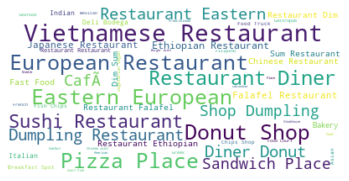

<Figure size 2160x3240 with 0 Axes>

In [35]:
# display the word cloud
plt.imshow(van_wordcloud, interpolation='bilinear')
plt.axis('off')

fig = plt.figure()
fig.set_figwidth(30)
fig.set_figheight(45)

plt.show()



In [60]:
# set number of clusters
kclusters = 15

vancouver_grouped_clustering = vancouver_mean_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(vancouver_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([ 0,  4,  4,  4, 10, 10, 12,  2,  0, 10])

In [37]:
# add clustering labels to sum of count of venue categories
if 'Cluster Labels' in vancouver_sum_grouped.columns:
    vancouver_sum_grouped.drop(['Cluster Labels'], axis=1)
else:
    vancouver_sum_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

vancouver_sum_grouped_cluster_labels = df_van_geo

# merge vancouver_sum_grouped with df_van_geo to add latitude/longitude for each neighborhood
vancouver_sum_grouped_cluster_labels = vancouver_sum_grouped_cluster_labels.join(vancouver_sum_grouped.set_index('Neighborhood'), on='Neighborhood')

vancouver_sum_grouped_cluster_labels # check the last columns

,CMA,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Breakfast Spot,Burger Joint,Burrito Place,Cafeteria,Café,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,Greek Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hot Dog Joint,Hotpot Restaurant,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Korean Restaurant,Kosher Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Molecular Gastronomy Restaurant,New American Restaurant,Noodle House,Pizza Place,Poke Place,Portuguese Restaurant,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,Soup Place,South Indian Restaurant,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Total
0,Vancouver,V2S,Abbotsford,Abbotsford-Southeast,49.039718,-122.285384,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0
1,Vancouver,V7X,Vancouver,Bentall Centre,49.286680,-123.120314,4.0,0.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,7.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,1.0,57.0
2,Vancouver,V5C,Burnaby,"Burnaby Heights, Willingdon Heights, West Cent...",49.276674,-123.007423,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0
3,Vancouver,V5G,Burnaby,"Cascade-Schou, Douglas-Gilpin",49.249305,-122.993815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Vancouver,V6K,Vancouver,"Central Kitsilano, Greektown",49.265317,-123.165650,4.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,2.0,2.0,29.0
5,Vancouver,V3E,Coquitlam,Coquitlam - North,49.312000,-122.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Vancouver,V3J,Coquitlam,Coquitlam-North,49.259878,-122.859912,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Vancouver,V3K,Coquitlam,Coquitlam-South,49.236467,-122.852141,10.0,0.0,1.0,0.0,0.0,0.0,0

In [66]:
# add clustering labels to top 10 sorted venues data frame
if 'Cluster Labels' in van_neighborhoods_venues_sorted.columns:
    van_neighborhoods_venues_sorted.drop(['Cluster Labels'], axis=1)
else:
    van_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

vancouver_cluster_labels = df_van_geo

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
vancouver_cluster_labels = vancouver_cluster_labels.join(van_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

vancouver_cluster_labels_nona = vancouver_cluster_labels.dropna()

vancouver_cluster_labels_nona['Cluster Labels'] = vancouver_cluster_labels_nona['Cluster Labels'].astype('int')

vancouver_cluster_labels_nona # check the last columns

<ipython-input-66-2f6e33e89f93>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vancouver_cluster_labels_nona['Cluster Labels'] = vancouver_cluster_labels_nona['Cluster Labels'].astype('int')


,CMA,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Vancouver,V2S,Abbotsford,Abbotsford-Southeast,49.039718,-122.285384,0,Chinese Restaurant,Pizza Place,Sushi Restaurant,Ethiopian Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
1,Vancouver,V7X,Vancouver,Bentall Centre,49.286680,-123.120314,4,Restaurant,Café,Food Truck,American Restaurant,Seafood Restaurant,Italian Restaurant,Japanese Restaurant,Steakhouse,Gastropub,Greek Restaurant
2,Vancouver,V5C,Burnaby,"Burnaby Heights, Willingdon Heights, West Cent...",49.276674,-123.007423,4,Japanese Restaurant,Mexican Restaurant,Sushi Restaurant,Café,Vietnamese Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant
4,Vancouver,V6K,Vancouver,"Central Kitsilano, Greektown",49.265317,-123.165650,4,Pizza Place,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Italian Restaurant,Café,French Restaurant,Indian Restaurant,Diner,Japanese Restaurant
7,Vancouver,V3K,Coquitlam,Coquitlam-South,49.236467,-122.852141,10,Vietnamese Restaurant,Sandwich Place,Fast Food Restaurant,Sushi Restaurant,Restaurant,Greek Restaurant,Dim Sum Restaurant,Deli / Bodega,Comfort Food Restaurant,Pizza Place
10,Vancouver,V4C,Delta,Delta-Northeast,49.156275,-122.910958,10,Pizza Place,Vietnamese Restaurant,Sandwich Place,Sushi Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
12,Vancouver,V4M,Delta,Delta-Southwest,49.031147,-123.089213,12,Pizza Place,Restaurant,Vietnamese Restaurant,Ethiopian Restaurant,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant
13,Vancouver,V3N,Burnaby,"East Big Bend, Stride Avenue, Edmonds, Cariboo...",49.226420,-122.930979,2,Indian Restaurant,Chinese Restaurant,Sushi Restaurant,Italian Restaurant,Falafel Restaurant,Dim Sum Restaurant,Diner,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
14,Vancouver,V5Z,Vancouver,"East Fairview, South Cambie",49.247477,-123.121233,0,Vietnamese Restaurant,Chinese Restaurant,Malay Restaurant,Sushi Restaurant,Cantonese Restaurant,Café,Cafeteria,Restaurant,Eastern European Restaurant,Donut Shop
15,Vancouver,V5T,Vancouver,East Mount Pleasant,49.263406,-123.090819,10,Vietnamese Restaurant,Sushi Restaurant,Ethiopian Restaurant,Food Truck,Pizza Place,Café,Bakery,Sandwich Place,Eastern European Restaurant,Dim Sum Restaurant


In [70]:
# get Vancouver, Canada latitude and longitude
address = 'Vancouver, Canada'

geolocator = Nominatim(user_agent="van_explorer")
location = geolocator.geocode(address)
van_latitude = location.latitude
van_longitude = location.longitude
print('The geograpical coordinate of Vancouver are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Vancouver are 43.6534817, -79.3839347.


In [71]:
# create map
van_map_clusters = folium.Map(location=[van_latitude, van_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(vancouver_cluster_labels_nona['Latitude'], vancouver_cluster_labels_nona['Longitude'], vancouver_cluster_labels_nona['Neighborhood'], vancouver_cluster_labels_nona['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(van_map_clusters)
       
van_map_clusters

#### Toronto

In [39]:
# one hot encoding
toronto_onehot = pd.get_dummies(tor_neighborhood_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = tor_neighborhood_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Creperie,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hakka Restaurant,Hot Dog Joint,Indian Restaurant,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Peking Duck Restaurant,Persian Restaurant,Pizza Place,Poke Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Agincourt,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Agincourt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Agincourt,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Alderwood, Long Branch",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Alderwood, Long Branch",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [40]:
toronto_onehot.shape

(1659, 92)

In [41]:
#group by neighborhood and sum count of venue categories
toronto_sum_grouped = toronto_onehot.groupby('Neighborhood').sum().reset_index()
toronto_sum_grouped['Total'] = toronto_sum_grouped.sum(axis=1)
toronto_sum_grouped

,Neighborhood,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Creperie,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hakka Restaurant,Hot Dog Joint,Indian Restaurant,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Peking Duck Restaurant,Persian Restaurant,Pizza Place,Poke Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Total
0,Agincourt,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
1,"Alderwood, Long Branch",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
2,"Bathurst Manor, Wilson Heights, Downsview North",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,9
3,Bayview Village,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
4,"Bedford Park, Lawrence Manor East",0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,2,0,0,0,2,0,0,0,0,21
5,Berczy Park,0,1,0,0,0,1,1,4,1,2,0,1,0,0,0,3,0,0,0,0,1,1,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,2,0,0,1,0,1,3,1,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,1,0,0,1,0,0,3,0,4,2,0,0,0,0,0,2,3,0,0,1,1,0,2,0,0,52
6,"Birch Cliff, Cliffside West",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
7,"Brockton, Parkdale Village, Exhibition Place",0,0,0,0,0,0,0,2,0,0,0,2,0,1,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,17
8,"Business reply mail Processing Centre, South C...",0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
9,"CN Tower, King and Spadina, Railway Lands, Har...",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2


In [42]:
toronto_sum_grouped.shape

(88, 93)

In [43]:
# examine sum of top 5 venues in each neighborhood
tor_num_top_venues = 6

for hood in toronto_sum_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_sum_grouped[toronto_sum_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','sum']
    temp = temp.iloc[2:]
    temp['sum'] = temp['sum'].astype(int)
    #temp = temp.round({'freq': 2})
    print(temp.sort_values('sum', ascending=False).reset_index(drop=True).head(tor_num_top_venues))
    print('\n')

----Agincourt----
                       venue  sum
0                      Total    3
1  Latin American Restaurant    1
2         Chinese Restaurant    1
3             Breakfast Spot    1
4        Moroccan Restaurant    0
5          Polish Restaurant    0


----Alderwood, Long Branch----
                             venue  sum
0                            Total    4
1                      Pizza Place    2
2                   Sandwich Place    1
3                     Burger Joint    1
4  Molecular Gastronomy Restaurant    0
5                       Poke Place    0


----Bathurst Manor, Wilson Heights, Downsview North----
            venue  sum
0           Total    9
1           Diner    1
2     Pizza Place    1
3   Deli / Bodega    1
4      Restaurant    1
5  Sandwich Place    1


----Bayview Village----
                 venue  sum
0                Total    4
1                 Café    1
2  Japanese Restaurant    1
3     Asian Restaurant    1
4   Chinese Restaurant    1
5    Polish Restau

                             venue  sum
0                            Total    4
1                    Hot Dog Joint    2
2            Vietnamese Restaurant    1
3             Fast Food Restaurant    1
4  Molecular Gastronomy Restaurant    0
5                      Pizza Place    0


----Lawrence Park----
                   venue  sum
0                  Total    1
1     Dim Sum Restaurant    1
2            Wings Joint    0
3  Vietnamese Restaurant    0
4             Poke Place    0
5            Pizza Place    0


----Leaside----
              venue  sum
0             Total   21
1  Sushi Restaurant    4
2       Pizza Place    3
3    Sandwich Place    3
4      Burger Joint    2
5    Breakfast Spot    2


----Little Portugal, Trinity----
                venue  sum
0               Total   43
1    Asian Restaurant    3
2          Restaurant    2
3   French Restaurant    2
4                Café    2
5  Mexican Restaurant    2


----Malvern, Rouge----
                  venue  sum
0              

In [44]:
toronto_mean_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_mean_grouped

,Neighborhood,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Creperie,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hakka Restaurant,Hot Dog Joint,Indian Restaurant,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Peking Duck Restaurant,Persian Restaurant,Pizza Place,Poke Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Agincourt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"Alderwood, Long Branch",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.111111,0.000000,0.000000,0.0

In [45]:
toronto_mean_grouped.shape

(88, 92)

In [46]:
# examine frequency of top 5 venues in each neighborhood
tor_num_top_venues = 5

for hood in toronto_mean_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_mean_grouped[toronto_mean_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(tor_num_top_venues))
    print('\n')

----Agincourt----
                             venue  freq
0        Latin American Restaurant  0.33
1               Chinese Restaurant  0.33
2                   Breakfast Spot  0.33
3                Afghan Restaurant  0.00
4  Molecular Gastronomy Restaurant  0.00


----Alderwood, Long Branch----
                venue  freq
0         Pizza Place  0.50
1        Burger Joint  0.25
2      Sandwich Place  0.25
3   Polish Restaurant  0.00
4  Persian Restaurant  0.00


----Bathurst Manor, Wilson Heights, Downsview North----
                 venue  freq
0        Deli / Bodega  0.11
1  Fried Chicken Joint  0.11
2          Pizza Place  0.11
3           Restaurant  0.11
4   Chinese Restaurant  0.11


----Bayview Village----
                 venue  freq
0  Japanese Restaurant  0.25
1     Asian Restaurant  0.25
2   Chinese Restaurant  0.25
3                 Café  0.25
4    Afghan Restaurant  0.00


----Bedford Park, Lawrence Manor East----
                venue  freq
0         Pizza Place  0.14
1  

                        venue  freq
0                      Bakery   0.4
1           Indian Restaurant   0.2
2                  Restaurant   0.2
3          Chinese Restaurant   0.2
4  Modern European Restaurant   0.0


----Guildwood, Morningside, West Hill----
                venue  freq
0         Pizza Place   0.2
1          Restaurant   0.2
2              Bakery   0.2
3  Mexican Restaurant   0.2
4      Breakfast Spot   0.2


----Harbourfront East, Union Station, Toronto Islands----
                  venue  freq
0            Restaurant  0.12
1                  Café  0.09
2           Pizza Place  0.07
3  Fast Food Restaurant  0.07
4    Chinese Restaurant  0.06


----High Park, The Junction South----
                venue  freq
0                Café  0.12
1  Mexican Restaurant  0.12
2     Thai Restaurant  0.12
3              Bakery  0.12
4               Diner  0.06


----Hillcrest Village----
                        venue  freq
0    Mediterranean Restaurant   0.5
1        Fast Food Resta

                       venue  freq
0          Indian Restaurant   0.2
1             Sandwich Place   0.2
2       Fast Food Restaurant   0.2
3  Middle Eastern Restaurant   0.1
4                 Restaurant   0.1


----Toronto Dominion Centre, Design Exchange----
                venue  freq
0          Restaurant  0.11
1                Café  0.10
2      Sandwich Place  0.06
3  Italian Restaurant  0.06
4         Salad Place  0.05


----University of Toronto, Harbord----
            venue  freq
0            Café  0.23
1  Sandwich Place  0.13
2      Restaurant  0.10
3          Bakery  0.07
4      Food Truck  0.07


----Victoria Village----
                   venue  freq
0          Deli / Bodega  0.25
1      French Restaurant  0.25
2            Pizza Place  0.25
3  Portuguese Restaurant  0.25
4      Korean Restaurant  0.00


----Westmount----
                       venue  freq
0                Pizza Place   0.4
1         Chinese Restaurant   0.2
2             Sandwich Place   0.2
3  Middle Eas

In [47]:
# create new dataframe with neighborhood and venue information and display top 10 venues by neighborhood
tor_num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(tor_num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
tor_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
tor_neighborhoods_venues_sorted['Neighborhood'] = toronto_mean_grouped['Neighborhood']

for ind in np.arange(toronto_mean_grouped.shape[0]):
    tor_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_mean_grouped.iloc[ind, :], tor_num_top_venues)

tor_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Breakfast Spot,Chinese Restaurant,Latin American Restaurant,Filipino Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant
1,"Alderwood, Long Branch",Pizza Place,Sandwich Place,Burger Joint,Wings Joint,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Pizza Place,Deli / Bodega,Fried Chicken Joint,Chinese Restaurant,Diner,Sushi Restaurant,Restaurant,Middle Eastern Restaurant,Sandwich Place,Eastern European Restaurant
3,Bayview Village,Asian Restaurant,Chinese Restaurant,Japanese Restaurant,Café,Wings Joint,Filipino Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Pizza Place,Restaurant,Sushi Restaurant,Sandwich Place,Thai Restaurant,Café,Japanese Restaurant,Breakfast Spot,Comfort Food Restaurant


In [48]:
tor_neighborhoods_venues_sorted.shape

(88, 11)

In [49]:
tor_venues_conc = tor_neighborhoods_venues_sorted['1st Most Common Venue'].map(str) + ', ' + van_neighborhoods_venues_sorted['2nd Most Common Venue'].map(str) + ', ' + van_neighborhoods_venues_sorted['3rd Most Common Venue'].map(str) + ', ' + van_neighborhoods_venues_sorted['4th Most Common Venue'].map(str) + ', ' + van_neighborhoods_venues_sorted['5th Most Common Venue'].map(str) + ', ' + van_neighborhoods_venues_sorted['6th Most Common Venue'].map(str) + ', ' + van_neighborhoods_venues_sorted['7th Most Common Venue'].map(str) + ', ' + van_neighborhoods_venues_sorted['8th Most Common Venue'].map(str) + ', ' + van_neighborhoods_venues_sorted['9th Most Common Venue'].map(str) + ', ' + van_neighborhoods_venues_sorted['10th Most Common Venue'].map(str)

tor_wc = pd.DataFrame(tor_venues_conc, columns = ['Restaurants'])

tor_wc.to_csv('tor_wc.txt', sep=',', index=False)

In [50]:
tor_wc1 = open('tor_wc.txt', 'r').read()

In [51]:
stopwords = set(STOPWORDS)

# instantiate a word cloud object
tor_wordcloud = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
tor_wordcloud.generate(tor_wc1)

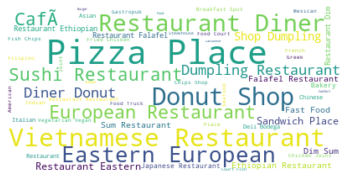

<Figure size 2160x3240 with 0 Axes>

In [52]:
# display the word cloud
plt.imshow(tor_wordcloud, interpolation='bilinear')
plt.axis('off')

fig = plt.figure()
fig.set_figwidth(30)
fig.set_figheight(45)

plt.show()

In [53]:
# set number of clusters
kclusters = 15

toronto_grouped_clustering = toronto_mean_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([13,  8,  2,  2,  2,  2,  2,  2,  3,  4])

In [54]:
# add clustering labels to sum of count of venue categories
if 'Cluster Labels' in toronto_sum_grouped.columns:
    toronto_sum_grouped.drop(['Cluster Labels'], axis=1)
else:
    toronto_sum_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_sum_grouped_cluster_labels = df_tor_geo

# merge vancouver_sum_grouped with df_van_geo to add latitude/longitude for each neighborhood
toronto_sum_grouped_cluster_labels = toronto_sum_grouped_cluster_labels.join(toronto_sum_grouped.set_index('Neighborhood'), on='Neighborhood')

toronto_sum_grouped_cluster_labels # check the last columns

,CMA,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Brazilian Restaurant,Breakfast Spot,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Creperie,Cuban Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hakka Restaurant,Hot Dog Joint,Indian Restaurant,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mac & Cheese Joint,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Molecular Gastronomy Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Peking Duck Restaurant,Persian Restaurant,Pizza Place,Poke Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Total
0,Toronto,M1S,Scarborough,Agincourt,43.794200,-79.262029,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
1,Toronto,M8W,Etobicoke,"Alderwood, Long Branch",43.602414,-79.543484,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,Toronto,M3H,North York,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
3,Toronto,M2K,North York,Bayview Village,43.786947,-79.385975,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
4,Toronto,M5M,North York,"Bedford Park, Lawrence Manor East",43.733283,-79.419750,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,21.0
5,Toronto,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,2.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,4.0,1.0,2.

In [73]:
# add clustering labels to top 10 sorted venues data frame
if 'Cluster Labels' in tor_neighborhoods_venues_sorted.columns:
    tor_neighborhoods_venues_sorted.drop(['Cluster Labels'], axis=1)
else:
    tor_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_cluster_labels = df_tor_geo

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_cluster_labels = toronto_cluster_labels.join(tor_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_cluster_labels_nona = toronto_cluster_labels.dropna()
toronto_cluster_labels_nona['Cluster Labels'] = toronto_cluster_labels_nona['Cluster Labels'].astype('int')
toronto_cluster_labels_nona # check the last columns

<ipython-input-73-6331bc1b7b43>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toronto_cluster_labels_nona['Cluster Labels'] = toronto_cluster_labels_nona['Cluster Labels'].astype('int')


,CMA,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Toronto,M1S,Scarborough,Agincourt,43.794200,-79.262029,13,Breakfast Spot,Chinese Restaurant,Latin American Restaurant,Filipino Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant
1,Toronto,M8W,Etobicoke,"Alderwood, Long Branch",43.602414,-79.543484,8,Pizza Place,Sandwich Place,Burger Joint,Wings Joint,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant
2,Toronto,M3H,North York,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259,2,Pizza Place,Deli / Bodega,Fried Chicken Joint,Chinese Restaurant,Diner,Sushi Restaurant,Restaurant,Middle Eastern Restaurant,Sandwich Place,Eastern European Restaurant
3,Toronto,M2K,North York,Bayview Village,43.786947,-79.385975,2,Asian Restaurant,Chinese Restaurant,Japanese Restaurant,Café,Wings Joint,Filipino Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
4,Toronto,M5M,North York,"Bedford Park, Lawrence Manor East",43.733283,-79.419750,2,Italian Restaurant,Pizza Place,Restaurant,Sushi Restaurant,Sandwich Place,Thai Restaurant,Café,Japanese Restaurant,Breakfast Spot,Comfort Food Restaurant
5,Toronto,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,2,Sandwich Place,Bakery,Italian Restaurant,Café,Restaurant,Sushi Restaurant,Seafood Restaurant,Greek Restaurant,Diner,Bistro
6,Toronto,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,2,Mediterranean Restaurant,Japanese Restaurant,Café,Pizza Place,Fast Food Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant
7,Toronto,M6K,West Toronto,"Brockton, Parkdale Village, Exhibition Place",43.636847,-79.428191,2,Café,Pizza Place,Breakfast Spot,Bakery,Sandwich Place,Italian Restaurant,Vietnamese Restaurant,Japanese Restaurant,Burrito Place,Restaurant
8,Toronto,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,3,Fast Food Restaurant,Restaurant,Burrito Place,Pizza Place,Wings Joint,Ethiopian Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner,Doner Restaurant
9,Toronto,M6E,York,Caledonia-Fairbanks,43.689026,-79.453512,0,Bakery,Wings Joint,Filipino Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant


In [77]:
# get Toronto, Canada latitude and longitude
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="van_explorer")
location = geolocator.geocode(address)
tor_latitude = location.latitude
tor_longitude = location.longitude
print('The geograpical coordinate of Vancouver are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Vancouver are 43.6534817, -79.3839347.


In [79]:
# create map
tor_map_clusters = folium.Map(location=[tor_latitude, tor_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_cluster_labels_nona['Latitude'], toronto_cluster_labels_nona['Longitude'], toronto_cluster_labels_nona['Neighborhood'], toronto_cluster_labels_nona['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(tor_map_clusters)
       
tor_map_clusters